<a href="https://www.kaggle.com/code/jetty2307/teams-clustering?scriptVersionId=104101837" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

pd.options.mode.chained_assignment = None  

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/football-events/ginf.csv
/kaggle/input/football-events/dictionary.txt
/kaggle/input/football-events/events.csv


 # We aim to cluster the teams from different leagues according to their play style. 

For that we will use such parameters as events (fouls, attempts, ...), their locations (wings, midfield, ...), assist methods (short passes, crosses, ...), situations (open play and different set pieces) and body parts involved (feet or head). 

Credits to IBM ML Coursera course for the idea of the agglomerative algorithm.

We will count all required parameters and group them by teams, having 46 features in total.

In [2]:
df = pd.read_csv('/kaggle/input/football-events/events.csv', delimiter=',')

df1 = df[['event_team','event_type', 'event_type2','location', 'assist_method', 'situation', 'bodypart']]

df1.groupby('event_team')
df2 = df1.groupby('event_team', group_keys=False)
k = df1['event_team'].sort_values().unique()

appended_data = []

for col in df1.columns[df1.columns != 'event_team']: 
    appended_data.append(df2[col].value_counts(dropna=True).sort_index().unstack(col).add_prefix(col+'_'))

df3 = pd.concat(appended_data, axis=1)    
df3['Event team'] = k
df3.head()

,event_type_1,event_type_2,event_type_3,event_type_4,event_type_5,event_type_6,event_type_7,event_type_8,event_type_9,event_type_10,...,assist_method_3,assist_method_4,situation_1.0,situation_2.0,situation_3.0,situation_4.0,bodypart_1.0,bodypart_2.0,bodypart_3.0,Event team
event_team,,,,,,,,,,,,,,,,,,,,,
AC Ajaccio,1106.0,449.0,1593.0,238.0,NaN,12.0,307.0,1534.0,365.0,96.0,...,43.0,31.0,913,86,74,33,566,374,166,AC Ajaccio
AC Milan,3065.0,1225.0,2677.0,499.0,3.0,18.0,593.0,2840.0,543.0,128.0,...,61.0,106.0,2615,144,219,87,1936,788,341,AC Milan
AJ Auxerre,446.0,178.0,558.0,89.0,NaN,3.0,104.0,469.0,94.0,35.0,...,16.0,20.0,364,18,41,23,199,178,69,AJ Auxerre
AS Monaco,1665.0,727.0,1666.0,243.0,NaN,8.0,385.0,1736.0,285.0,106.0,...,49.0,53.0,1387,86,142,50,797,574,294,AS Monaco
AS Nancy Lorraine,1058.0,356.0,1260.0,160.0,NaN,7.0,232.0,1174.0,254.0,67.0,...,42.0,33.0,874,69,86,29,651,239,168,AS Nancy Lorraine


As different teams can have a different number of games, we will count games for each team (home and away) and normalize all features by the number of games.

In [3]:
ginf = pd.read_csv('/kaggle/input/football-events/ginf.csv')
ginf.head()

gam = ginf['ht'].value_counts() + ginf['at'].value_counts()

df3['games'] = gam
df3.head(5)

for i in df3.columns:
    if (type(df3[i][0]) == np.float64) | (type(df3[i][0]) == np.int64):
        df3[i] = df3[i].div(gam, axis=0)

Let's get rid of all decimals in column names.

In [4]:
df3.rename(columns={'location_10.0': 'location_10'}, inplace = True)
#df3['games'] = gam
for col in df3.columns:   
    if col.endswith('.0'):
        col1 = col.strip('.0')
    else:
        col1 = col
    df3 = df3.rename(columns={col : col1})   

print(df3.columns)

Index(['event_type_1', 'event_type_2', 'event_type_3', 'event_type_4',
       'event_type_5', 'event_type_6', 'event_type_7', 'event_type_8',
       'event_type_9', 'event_type_10', 'event_type_11', 'event_type2_12',
       'event_type2_13', 'event_type2_14', 'event_type2_15', 'location_1',
       'location_2', 'location_3', 'location_4', 'location_5', 'location_6',
       'location_7', 'location_8', 'location_9', 'location_10', 'location_11',
       'location_12', 'location_13', 'location_14', 'location_15',
       'location_16', 'location_17', 'location_18', 'location_19',
       'assist_method_0', 'assist_method_1', 'assist_method_2',
       'assist_method_3', 'assist_method_4', 'situation_1', 'situation_2',
       'situation_3', 'situation_4', 'bodypart_1', 'bodypart_2', 'bodypart_3',
       'Event team', 'games'],
      dtype='object')


Now we will use the dictionary to decode all parameters and give columns user-friendly names.

In [5]:
f = open("/kaggle/input/football-events/dictionary.txt", "r")

x = []
k = []
r = []
for lines in f:
    x.append(lines.split())

line_base = x[0][0]

for line in x:
    if len(line) > 1:        
        ll = ''
        for j in range(1, len(line)):
            if j < (len(line) - 1):
                ll = ll + line[j] + ' '
            else:
                ll = ll + line[j]
        k.append([line_base + '_' + line[0], ll])
                
    elif len(line) == 1:
        line_base = line[0]
print(k)

[['event_type_0', 'Announcement'], ['event_type_1', 'Attempt'], ['event_type_2', 'Corner'], ['event_type_3', 'Foul'], ['event_type_4', 'Yellow card'], ['event_type_5', 'Second yellow card'], ['event_type_6', 'Red card'], ['event_type_7', 'Substitution'], ['event_type_8', 'Free kick won'], ['event_type_9', 'Offside'], ['event_type_10', 'Hand ball'], ['event_type_11', 'Penalty conceded'], ['event_type2_12', 'Key Pass'], ['event_type2_13', 'Failed through ball'], ['event_type2_14', 'Sending off'], ['event_type2_15', 'Own goal'], ['side_1', 'Home'], ['side_2', 'Away'], ['shot_place_1', 'Bit too high'], ['shot_place_2', 'Blocked'], ['shot_place_3', 'Bottom left corner'], ['shot_place_4', 'Bottom right corner'], ['shot_place_5', 'Centre of the goal'], ['shot_place_6', 'High and wide'], ['shot_place_7', 'Hits the bar'], ['shot_place_8', 'Misses to the left'], ['shot_place_9', 'Misses to the right'], ['shot_place_10', 'Too high'], ['shot_place_11', 'Top centre of the goal'], ['shot_place_12', 

In [6]:
i = 0
for col in k:    
    if col[0] in df3.columns:        
        df3 = df3.rename(columns={col[0] : col[1]})
    
print(df3.columns)

Index(['Attempt', 'Corner', 'Foul', 'Yellow card', 'Second yellow card',
       'Red card', 'Substitution', 'Free kick won', 'Offside', 'Hand ball',
       'Penalty conceded', 'Key Pass', 'Failed through ball', 'Sending off',
       'Own goal', 'Attacking half', 'Defensive half', 'Centre of the box',
       'Left wing', 'Right wing', 'Difficult angle and long range',
       'Difficult angle on the left', 'Difficult angle on the right',
       'Left side of the box', 'Left side of the six yard box',
       'Right side of the box', 'Right side of the six yard box',
       'Very close range', 'Penalty spot', 'Outside the box', 'Long range',
       'More than 35 yards', 'More than 40 yards', 'Not recorded', 'None',
       'Pass', 'Cross', 'Headed pass', 'Through ball', 'Open play',
       'Set piece', 'Corner', 'Free kick', 'right foot', 'left foot', 'head',
       'Event team', 'games'],
      dtype='object')


In [7]:
df3.drop('Not recorded', axis=1, inplace=True)

When comparing playing styles, it doesn't make sense to distinguish right from left, so we will merge corresponding columns.

In [8]:
def column_sum(a,b):
    c = df3[[a,b]].sum(axis=1)    
    df3.drop([a,b], axis=1, inplace=True)
    return c    

df3['Foot'] = column_sum('right foot','left foot')
df3['Wing'] = column_sum('Right wing','Left wing')
df3['Difficult angle'] = column_sum('Difficult angle on the left','Difficult angle on the right')
df3['Side of the box'] = column_sum('Left side of the box','Right side of the box')
df3['Side of the six yard box'] = column_sum('Left side of the six yard box','Right side of the six yard box')


We do some cleaning and look at the data frame.

In [9]:
df3.rename(columns={'head': 'Head'}, inplace = True) 
df3.drop('games', axis=1, inplace=True)
df3.drop('Second yellow card', axis=1, inplace=True)

In [10]:
df3.dropna(axis=0,inplace=True)
df3.head()

,Attempt,Corner,Foul,Yellow card,Red card,Substitution,Free kick won,Offside,Hand ball,Penalty conceded,...,Set piece,Corner,Free kick,Head,Event team,Foot,Wing,Difficult angle,Side of the box,Side of the six yard box
event_team,,,,,,,,,,,,,,,,,,,,,
AC Ajaccio,9.701754,3.938596,13.973684,2.087719,0.105263,2.692982,13.456140,3.201754,0.842105,0.131579,...,0.754386,0.649123,0.289474,1.456140,AC Ajaccio,8.245614,3.500000,0.166667,1.429825,0.219298
AC Milan,14.595238,5.833333,12.747619,2.376190,0.085714,2.823810,13.523810,2.585714,0.609524,0.200000,...,0.685714,1.042857,0.414286,1.623810,AC Milan,12.971429,3.252381,0.300000,2.242857,0.300000
AS Monaco,12.333333,5.385185,12.340741,1.800000,0.059259,2.851852,12.859259,2.111111,0.785185,0.214815,...,0.637037,1.051852,0.370370,2.177778,AS Monaco,10.155556,3.562963,0.259259,1.918519,0.562963
AS Nancy Lorraine,11.020833,3.708333,13.125000,1.666667,0.072917,2.416667,12.229167,2.645833,0.697917,0.125000,...,0.718750,0.895833,0.302083,1.750000,AS Nancy Lorraine,9.270833,3.302083,0.156250,1.739583,0.302083
AS Roma,15.509524,6.019048,11.914286,2.304762,0.080952,2.833333,13.100000,2.176190,0.547619,0.190476,...,0.633333,1.223810,0.390476,1.776190,AS Roma,13.733333,2.833333,0.371429,2.695238,0.409524


Now let's apply the hierarchical agglomerative scipy clustering to the dataframe using scikit-learn preprocessing.

In [11]:
from sklearn.preprocessing import MinMaxScaler
featureset = df3.loc[:, df3.columns != 'Event team']
x = featureset.values 
min_max_scaler = MinMaxScaler()
feature_mtx = min_max_scaler.fit_transform(x)
feature_mtx [0:5]

from sklearn.metrics.pairwise import euclidean_distances
dist_matrix = euclidean_distances(feature_mtx,feature_mtx) 


In [12]:
from scipy.cluster import hierarchy 
print(dist_matrix)
Z_using_dist_matrix = hierarchy.linkage(dist_matrix, 'complete')

[[0.         1.93128291 1.87567683 ... 1.55844064 1.60096184 2.91734556]
 [1.93128291 0.         1.33715056 ... 1.58775843 1.46464259 3.58138195]
 [1.87567683 1.33715056 0.         ... 1.21672068 0.97328639 3.04641459]
 ...
 [1.55844064 1.58775843 1.21672068 ... 0.         1.28914073 2.60380723]
 [1.60096184 1.46464259 0.97328639 ... 1.28914073 0.         3.09708455]
 [2.91734556 3.58138195 3.04641459 ... 2.60380723 3.09708455 0.        ]]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


On the dendrogram, we can see 3 main clusters - English Premier League teams; top teams - Barcelona, Real Madrid, Bayern Munich; and rest of the teams - we can see local similarities between them.

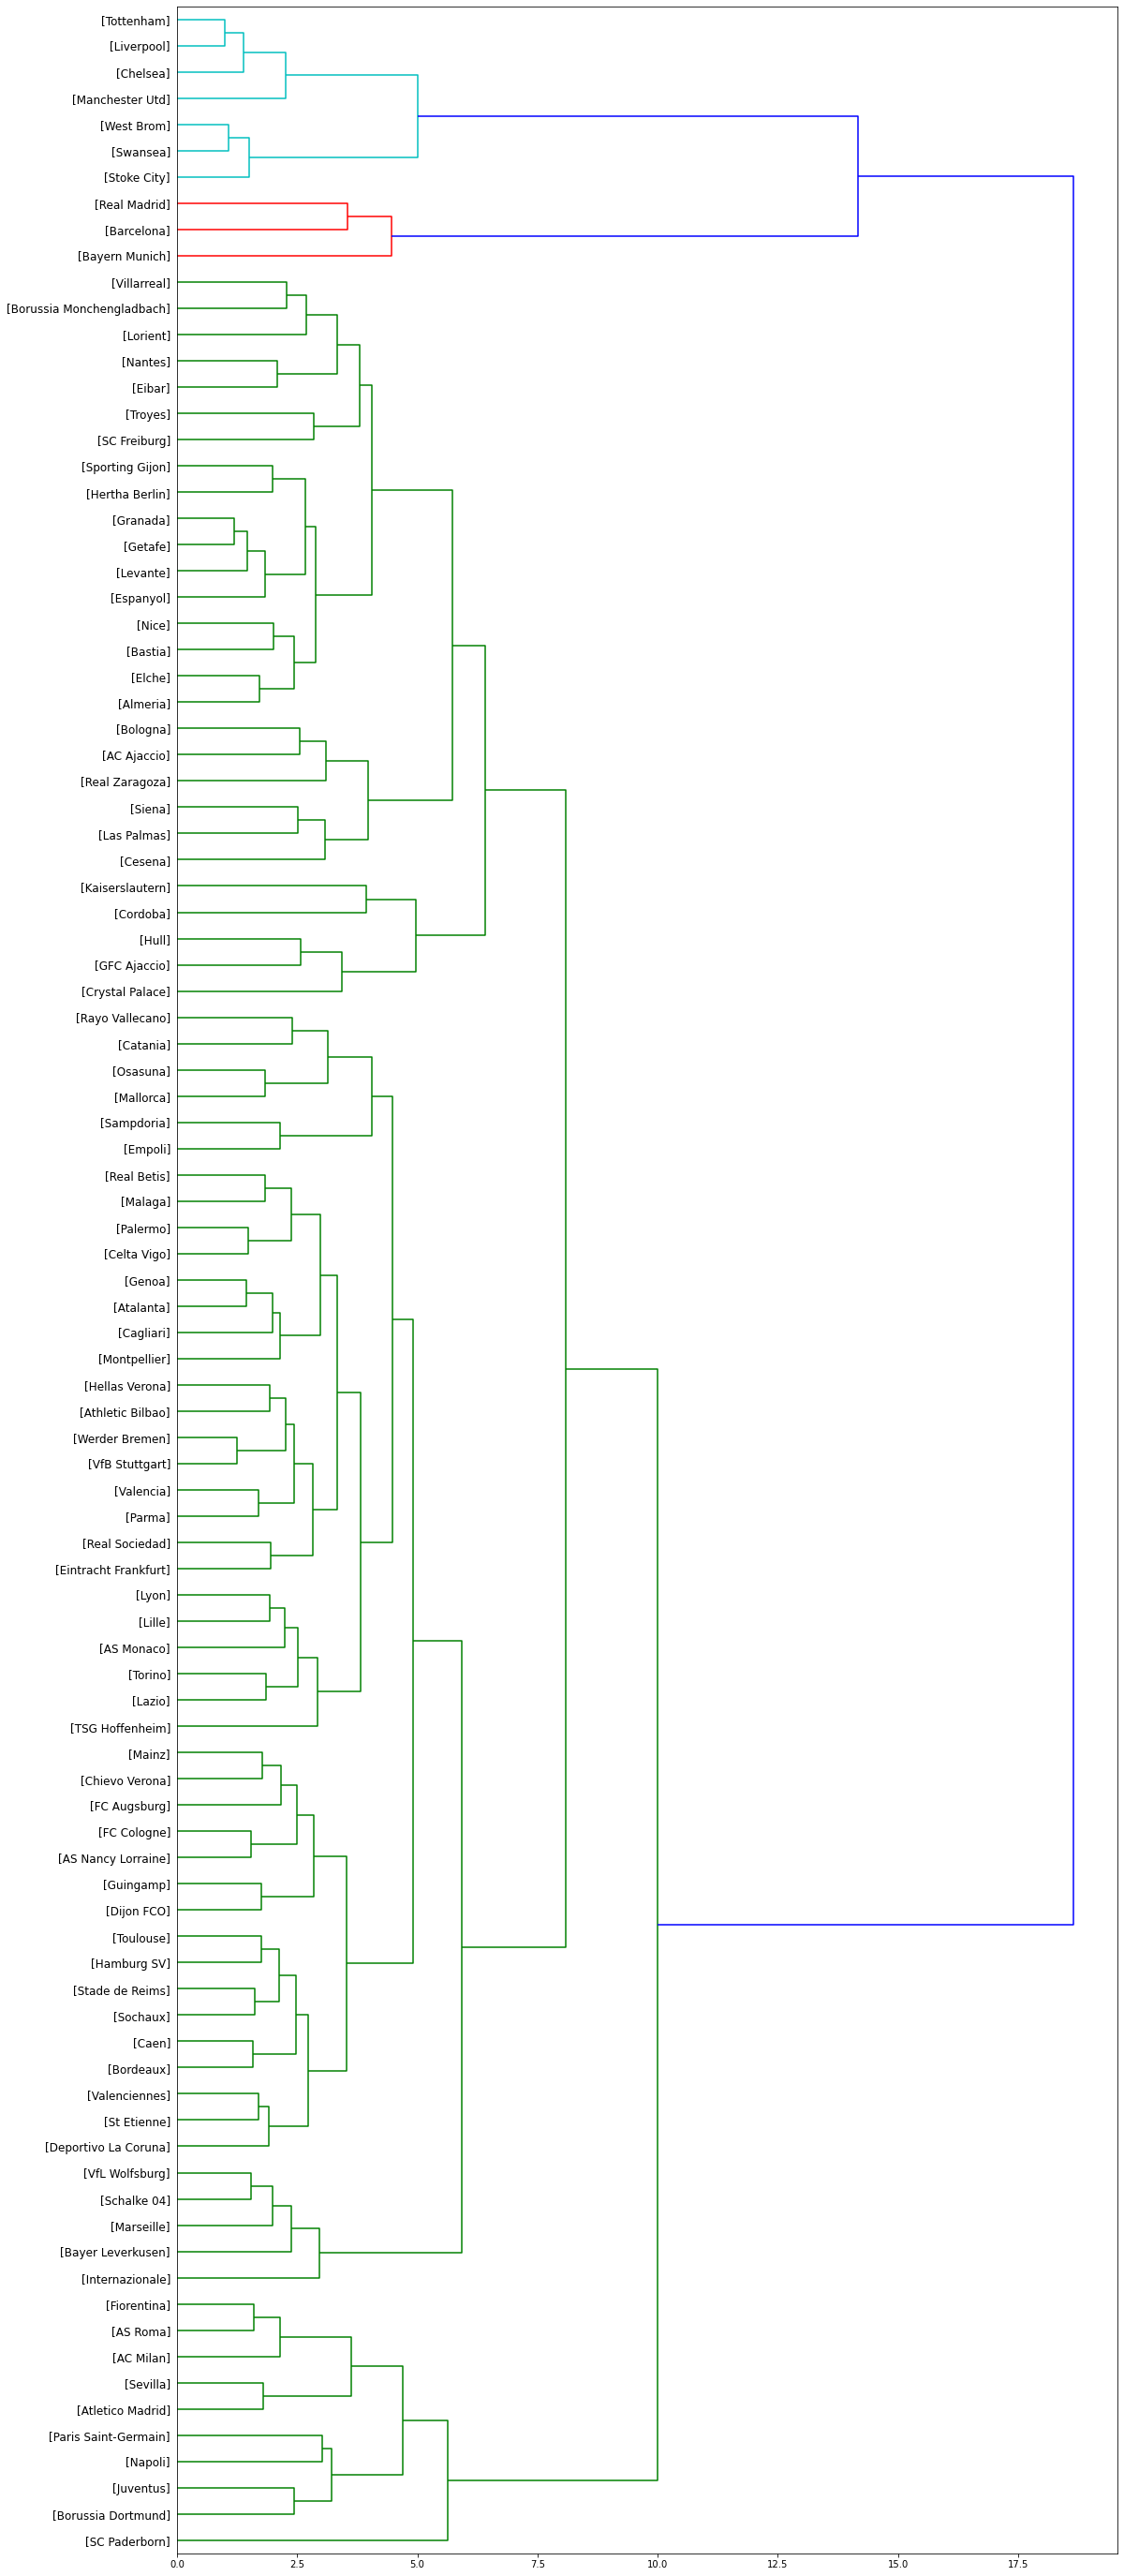

In [13]:
import pylab
from matplotlib import pyplot as plt
fig = pylab.figure(figsize=(18,50))
def llf(id):
    return '[%s]' % (df3['Event team'][id]) 
    
dendro = hierarchy.dendrogram(Z_using_dist_matrix,  leaf_label_func=llf, leaf_rotation=0, leaf_font_size =12, orientation = 'right')
plt.savefig('dendrogram.png')

Now we will imply scikit-learn agglomerative clustering.

In [14]:
from sklearn.cluster import AgglomerativeClustering
agglom = AgglomerativeClustering(n_clusters = 6, linkage = 'complete')
agglom.fit(dist_matrix)

agglom.labels_

/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_agglomerative.py:492: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


array([1, 4, 0, 0, 4, 1, 0, 0, 4, 5, 1, 0, 5, 1, 0, 4, 1, 0, 0, 0, 0, 1,
       3, 0, 2, 2, 0, 0, 1, 0, 1, 0, 1, 0, 0, 4, 2, 0, 1, 1, 0, 0, 0, 1,
       2, 0, 4, 2, 1, 0, 1, 0, 3, 1, 0, 0, 0, 0, 3, 0, 0, 1, 4, 1, 0, 0,
       4, 0, 0, 0, 5, 0, 1, 1, 4, 0, 0, 4, 1, 0, 1, 0, 0, 3, 3, 0, 0, 3,
       0, 1, 0, 0, 0, 0, 1, 0, 3])

In [15]:
df3['cluster_'] = agglom.labels_

We can also create a plot with labels to see spatial positions of the clusters. Let's plot attempts against fouls per game as the most basic features with substitutions as a point size.

Text(0, 0.5, 'Foul')

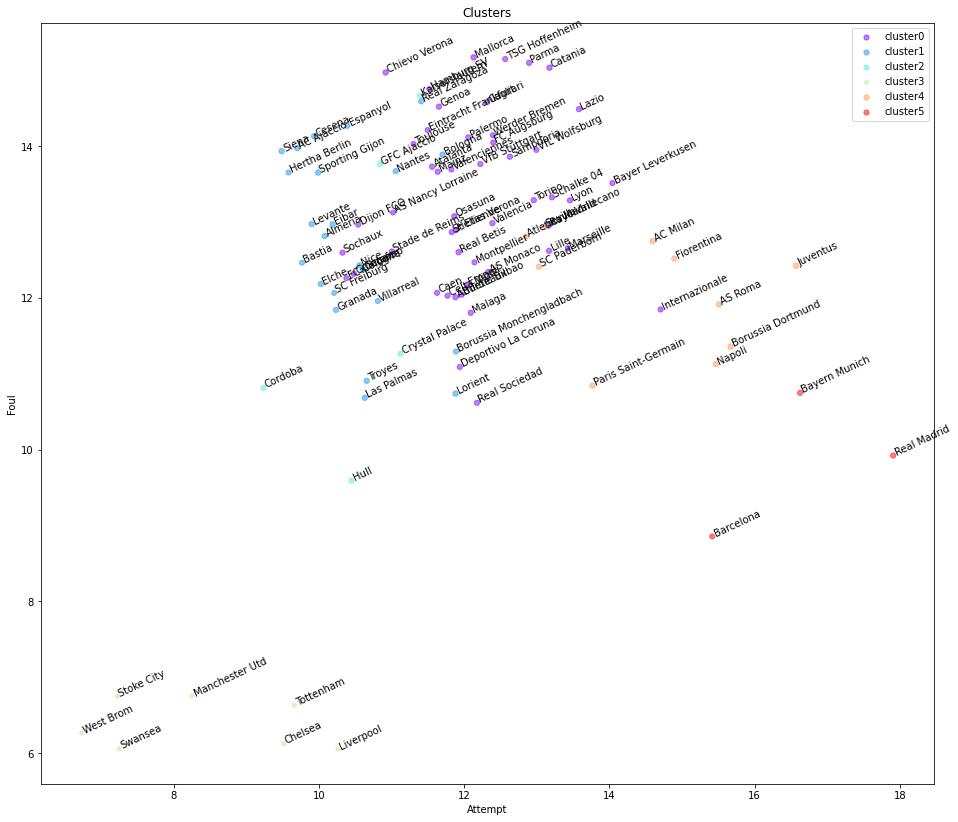

In [16]:
import matplotlib.cm as cm
n_clusters = max(agglom.labels_)+1
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
cluster_labels = list(range(0, n_clusters))

plt.figure(figsize=(16,14))

for color, label in zip(colors, cluster_labels):
    subset = df3[df3.cluster_ == label]
    for i in subset.index:
            plt.text(subset.Attempt[i], subset.Foul[i],str(subset['Event team'][i]), rotation=25) 
    plt.scatter(subset.Attempt, subset.Foul, s= subset.Substitution*10, c=color, label='cluster'+str(label),alpha=0.5)

plt.legend()
plt.title('Clusters')
plt.xlabel('Attempt')
plt.ylabel('Foul')

Although we defined more clusters here, we are still able to see 3 main clusters which we found out previously. The similarity of the top teams between each other - Madrid, Barcelona and Bayern - can be a result of dominating style of play in the national leagues in general which implies higher ball possession, more attempts, passes etc. The similarity of English teams between each other can be explained rather by peculiarities of statistics gathering in the league than by the same play style, as one can see top and non-top teams in the cluster.